#### Ref : https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_refit_callable.html#sphx-glr-auto-examples-model-selection-plot-grid-search-refit-callable-py

#### Author: Wenhao Zhang <wenhaoz@ucla.edu>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
#read and sample the data

# check multiple samples, and see class imbalance

data = pd.read_csv('signal-data.csv')
print(data.shape)
data.sample(10)

(1567, 592)


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
1215,2008-01-10 09:15:00,3051.02,2565.73,2165.5333,994.3737,0.7992,100.0,102.9378,0.1247,1.5391,...,NaN,0.5017,0.0102,0.0029,2.0255,0.0085,0.0064,0.0020,74.6027,-1
463,2008-08-28 04:10:00,2961.36,2362.09,2163.5889,1448.3869,1.7014,100.0,104.8333,0.1256,1.4680,...,NaN,0.5037,0.0106,0.0025,2.1099,0.0155,0.0101,0.0033,64.8825,-1
219,2008-08-16 13:51:00,2912.76,2480.54,2233.7666,1772.4931,0.9501,100.0,100.7256,0.1215,1.4029,...,170.5841,0.5040,0.0161,0.0043,3.1870,0.0095,0.0162,0.0063,170.5841,-1
1458,2008-11-10 07:39:00,2928.89,2504.81,2236.1111,1546.5931,2.0300,100.0,90.4233,0.1224,1.3663,...,NaN,0.4997,0.0142,0.0036,2.8319,-0.0031,0.0168,0.0061,545.6838,-1
717,2008-03-09 18:16:00,2943.83,2445.17,2236.0667,1680.1825,1.4834,100.0,98.6889,0.1221,1.4674,...,49.9454,0.5001,0.0190,0.0043,3.7940,0.0263,0.0131,0.0039,49.9454,-1
40,2008-07-28 15:11:00,2962.14,2545.71,2221.5778,1503.6230,1.1878,100.0,111.3444,0.1211,1.5424,...,45.4264,0.5068,0.0201,0.0046,3.9635,0.0189,0.0086,0.0032,45.4264,1
579,2008-08-30 11:12:00,3042.36,2493.85,2124.8444,1180.2820,0.8465,100.0,100.7978,0.1257,1.3725,...,NaN,0.4970,0.0143,0.0031,2.8703,0.0182,0.0139,0.0039,76.6094,-1
387,2008-08-21 23:53:00,2912.24,2555.49,2206.4222,1113.3443,1.2678,100.0,97.7689,0.1215,1.4313,...,NaN,0.5020,0.0114,0.0031,2.2798,0.0056,0.0071,0.0025,127.2483,-1
247,2008-08-18 05:03:00,3043.17,2483.74,2195.7666,1015.3046,1.3663,100.0,101.4600,0.1207,1.4925,...,NaN,0.5009,0.0120,0.0032,2.3974,0.0154,0.0271,0.0104,176.0329,-1
604,2008-08-31 10:36:00,2937.63,2499.72,2200.0666,1012.6747,1.3954,100.0,103.0644,0.1212,1.3946,...,NaN,0.5012,0.0146,0.0033,2.9192,0.0199,0.0159,0.0048,79.7752,-1


In [3]:
# Just for demo purpose/ build a quick dirty model, can we drop na ?
data.isna().sum().sort_values(ascending=False).head(75)

158    1429
292    1429
293    1429
157    1429
85     1341
       ... 
76       24
118      24
211      24
210      24
217      24
Length: 75, dtype: int64

In [4]:
y = data['Pass/Fail']
X = data.drop(columns=['Time', 'Pass/Fail'])

In [5]:
#Very basic imputation, better way ?
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X)
X = imputer.transform(X)
print(X.shape)

(1567, 590)


In [6]:
def lower_bound(cv_results):
    """
    Calculate the lower bound within 1 standard deviation
    of the best `mean_test_scores`.

    Parameters
    ----------
    cv_results : dict of numpy(masked) ndarrays
        See attribute cv_results_ of `GridSearchCV`

    Returns
    -------
    float
        Lower bound within 1 standard deviation of the
        best `mean_test_score`.
    """
    best_score_idx = np.argmax(cv_results['mean_test_score'])

    return (cv_results['mean_test_score'][best_score_idx]
            - cv_results['std_test_score'][best_score_idx])


def best_low_complexity(cv_results):
    """
    Balance model complexity with cross-validated score.

    Parameters
    ----------
    cv_results : dict of numpy(masked) ndarrays
        See attribute cv_results_ of `GridSearchCV`.

    Return
    ------
    int
        Index of a model that has the fewest PCA components
        while has its test score within 1 standard deviation of the best
        `mean_test_score`.
    """
    threshold = lower_bound(cv_results)
    candidate_idx = np.flatnonzero(cv_results['mean_test_score'] >= threshold)
    best_idx = candidate_idx[cv_results['param_reduce_dim__n_components']
                             [candidate_idx].argmin()]
    return best_idx

In [7]:
pipe = Pipeline([
        ('reduce_dim', PCA()),
        ('classify', KNeighborsClassifier()), #KNeighborsClassifier(n_neighbors=3)
])

param_grid = {
    'reduce_dim__n_components': [2, 4, 6, 8, 10, 12, 14]
}

### Issue with general Split ??

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(y_train.value_counts())
print(y_test.value_counts())

print("\nTrain set class ratio : ", round(y_train.value_counts()[1]/y_train.value_counts()[-1],2))
print("\nTest set class ratio : ", round(y_test.value_counts()[1]/y_test.value_counts()[-1],2))

-1    1170
 1      83
Name: Pass/Fail, dtype: int64
-1    293
 1     21
Name: Pass/Fail, dtype: int64

Train set class ratio :  0.07

Test set class ratio :  0.07


### Solve Class Imbalance

In [9]:
#Ref : https://scikit-learn.org/stable/modules/cross_validation.html#stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print(y_train.value_counts())
print(y_test.value_counts())
print("\nTrain set class ratio : ", round(y_train.value_counts()[1]/y_train.value_counts()[-1],2))
print("\nTest set class ratio : ", round(y_test.value_counts()[1]/y_test.value_counts()[-1],2))

-1    1170
 1      83
Name: Pass/Fail, dtype: int64
-1    293
 1     21
Name: Pass/Fail, dtype: int64

Train set class ratio :  0.07

Test set class ratio :  0.07


In [10]:
#stratified CV would be better ?

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid,
                    scoring='f1_weighted', refit=best_low_complexity)
grid.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('reduce_dim', PCA()),
                                       ('classify', KNeighborsClassifier())]),
             n_jobs=1,
             param_grid={'reduce_dim__n_components': [2, 4, 6, 8, 10, 12, 14]},
             refit=<function best_low_complexity at 0x7faba5b73430>,
             scoring='f1_weighted')

In [11]:
grid.cv_results_

{'mean_fit_time': array([0.02576604, 0.02763782, 0.02474651, 0.0255645 , 0.02796426,
        0.0276207 , 0.02687707]),
 'std_fit_time': array([0.00770668, 0.00328783, 0.00125754, 0.00231209, 0.00286578,
        0.00198283, 0.00243055]),
 'mean_score_time': array([0.007584  , 0.0086297 , 0.00771897, 0.00826633, 0.00858657,
        0.00811632, 0.00855618]),
 'std_score_time': array([0.00068595, 0.00107477, 0.00039226, 0.00039417, 0.00097937,
        0.00054698, 0.00043061]),
 'param_reduce_dim__n_components': masked_array(data=[2, 4, 6, 8, 10, 12, 14],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'reduce_dim__n_components': 2},
  {'reduce_dim__n_components': 4},
  {'reduce_dim__n_components': 6},
  {'reduce_dim__n_components': 8},
  {'reduce_dim__n_components': 10},
  {'reduce_dim__n_components': 12},
  {'reduce_dim__n_components': 14}],
 'split0_test_score': array([0.90231444, 0.89910153, 0.9108280

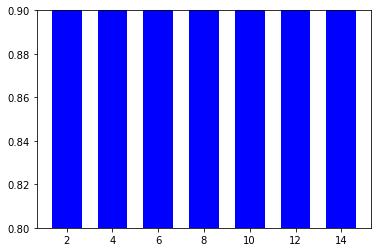

In [12]:
n_components = grid.cv_results_['param_reduce_dim__n_components']
test_scores = grid.cv_results_['mean_test_score']

plt.figure()
plt.ylim((0.8, 0.9))
plt.bar(n_components, test_scores, width=1.3, color='b')

lower = lower_bound(grid.cv_results_)

<BarContainer object of 7 artists>

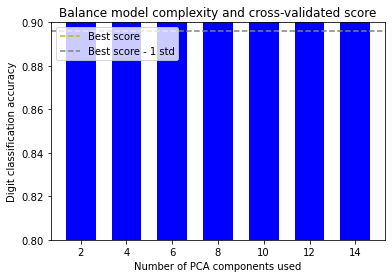

In [13]:
plt.axhline(np.max(test_scores), linestyle='--', color='y',
            label='Best score')
plt.axhline(lower, linestyle='--', color='.5', label='Best score - 1 std')

plt.title("Balance model complexity and cross-validated score")
plt.xlabel('Number of PCA components used')
plt.ylabel('Digit classification accuracy')
plt.xticks(n_components.tolist())
plt.ylim((0.8, 0.9))
plt.legend(loc='upper left')

plt.bar(n_components, test_scores, width=1.3, color='b')